In [1]:
import copy

import IPython.core.display_functions
# Imports
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

import ray
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib import Policy


from src.parsers import HMParser, CotevParser
from src.resources import Aggregator, Generator, Load, Storage, Vehicle
from src.algorithms.rl import EnergyCommunityMultiEnv_v2

import warnings
warnings.filterwarnings('ignore')

2024-05-07 23:34:28,707	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

# EC data for non-renewable generators and batteries
data_ec = HMParser(file_path='/Users/ecgomes/DataspellProjects/pyecom/data/EC_V4.xlsx', ec_id=1)
data_ec.parse()

# EV data from the EV4EU simulator
data_ev = CotevParser(population_path=
                      '/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/population_731.csv',
                      driving_history_path=
                      '/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/ev_driving_history_731.csv',
                      assigned_segments_path='/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/assigned_segments_731.csv',
                      parse_date_start='2019',
                      parse_date_end='2020')
data_ev.parse()

In [3]:
# UPAC Data load

data_upacs = {}
for i in glob.glob('/Users/ecgomes/Documents/PhD/UPAC data/upac*_pv.csv'):
    temp = pd.read_csv(i, index_col=0, parse_dates=True)
    temp = temp.resample('H').mean()
    
    # Need to divide by 1000 to convert from W to kW
    temp['pv'] = temp['pv'] / 1000
    temp['load'] = temp['load'] / 1000
    
    # We only want 2019 and 2020 data
    temp = temp.loc['2019':'2020']
    
    # Fill potential NaN values with interpolation
    temp = temp.interpolate()
    
    name = i.split('/')[-1].split('_')[0].split('upac')[1]
    
    data_upacs[name] = temp

In [4]:
# Sanity check for upac and ev dimensions

print('UPAC data:')
for i in data_upacs.keys():
    print('UPAC {}: {}'.format(i, data_upacs[i].shape))
    
print('\nEV data:')
for i in range(len(data_ev.resources)):
    print('EV {}: {}'.format(i, data_ev.resources[i].lower_bound.shape))

UPAC data:
UPAC 08: (17544, 2)
UPAC 06: (17544, 2)
UPAC 02: (17544, 2)
UPAC 09: (17544, 2)
UPAC 13: (17544, 2)

EV data:
EV 0: (17544,)
EV 1: (17544,)
EV 2: (17544,)
EV 3: (17544,)
EV 4: (17544,)


In [5]:
# Train resource creation

def create_resources(upacs, ec, ev):
    """
    Create the resources for the training environment.
    return a list of resources.
    :param upacs: dict with the UPAC data
    :param ec: dict with the EC data
    :param ev: dict with the EV data
    """
    
    resources = []
    
    # Add generators (from pv column from the UPAC data)
    for i in range(len(upacs)):
        current_name = list(upacs.keys())[i]
        resources.append(Generator(
            name='generator_' + current_name,
            value=np.zeros(upacs[current_name]['pv'].shape),
            lower_bound=np.zeros(upacs[current_name]['pv'].shape),
            upper_bound=upacs[current_name]['pv'].values,
            cost=ec.generator['cost_parameter_b'][0] * np.ones(upacs[current_name].shape[0]),
            cost_nde=ec.generator['cost_nde'][0],
            is_renewable=True))
        
    # Add loads (from load column from the UPAC data)
    for i in range(len(upacs)):
        current_name = list(upacs.keys())[i]
        resources.append(Load(
            name='load_' + current_name,
            value=upacs[current_name]['load'],
            lower_bound=np.zeros(upacs[current_name].shape),
            upper_bound=upacs[current_name]['load'].values,
            cost=np.ones(upacs[current_name].shape[0]),
            cost_cut=ec.load['cost_cut'][0],
            cost_reduce=ec.load['cost_reduce'][0],
            cost_ens=ec.load['cost_ens'][0]))
        
    # Add storage (from the EC data)
    for i in range(ec.storage['p_charge_limit'].shape[0]):
        resources.append(Storage(
            name='storage_{:02d}'.format(i+1),
            value=ec.storage['initial_state'][i] * np.ones(upacs['02'].shape[0]),
            lower_bound=np.ones(upacs['02'].shape[0]) * ec.storage['energy_min_percentage'][i],
            upper_bound=(ec.storage['energy_capacity'][i] * np.ones(upacs['02'].shape[0])),
            cost=np.ones(upacs['02'].shape[0]),
            cost_discharge=np.tile(ec.storage['discharge_price'][i], (int(upacs['02'].shape[0] / 24))),
            cost_charge=np.tile(ec.storage['charge_price'][i], (int(upacs['02'].shape[0] / 24))),
            capacity_max=ec.storage['energy_capacity'][i],
            capacity_min=ec.storage['energy_min_percentage'][i],
            initial_charge=ec.storage['initial_state'][i],
            discharge_efficiency=ec.storage['discharge_efficiency'][i],
            discharge_max=np.tile(ec.storage['p_discharge_limit'][i], (int(upacs['02'].shape[0] / 24))),
            charge_efficiency=ec.storage['charge_efficiency'][i],
            charge_max=np.tile(ec.storage['p_charge_limit'][i], (int(upacs['02'].shape[0] / 24))),
            capital_cost=np.array([0.05250, 0.10500, 0.01575])))
        
    # Add vehicles (from the EV data)
    for i in np.arange(len(ev)):
        # Append to the list of resources
        resources.append(ev[i])
    
    # Append Aggregator
    resources.append(Aggregator(
        name='aggregator',
        value=np.zeros(upacs['02'].shape[0]),
        lower_bound=np.zeros(upacs['02'].shape[0]),
        upper_bound=np.tile(ec.peers['import_contracted_p_max'][0, 0], (upacs['02'].shape[0])),
        cost=np.tile(ec.peers['buy_price'][0, 0], (upacs['02'].shape[0])),
        imports=np.zeros(upacs['02'].shape[0]),
        exports=np.zeros(upacs['02'].shape[0]),
        import_cost=np.tile(ec.peers['buy_price'][0, 0], (int(upacs['02'].shape[0]))), # * 100,
        export_cost=np.tile(ec.peers['sell_price'][0, 0], (int(upacs['02'].shape[0]))),
        import_max=np.tile(ec.peers['import_contracted_p_max'][0, 0], (int(upacs['02'].shape[0]))),
        export_max=np.tile(ec.peers['export_contracted_p_max'][0, 0], (int(upacs['02'].shape[0])))))
    
    return resources

In [6]:
# Create resources for the training environment

def iterate_resources(u, c, e):
    
    temp = {}
    
    # Save first key of upac data
    first_key = list(u.keys())[0]
    
    # Loop to iterate over days in the datasets
    for i in np.unique(u[first_key].index.date):
        # Create the resources for the training environment
        
        date = i.strftime('%Y-%m-%d')
        
        temp_u = {k: v.loc[date] for k, v in u.items()}
        temp_e = e.create_resources(e.population, e.trips_grid, e.assigned_segments, date)
        
        temp[date] = create_resources(upacs=temp_u,
                                      ec=c,
                                      ev=temp_e)
        
    return temp

dataset_resources = iterate_resources(u=data_upacs, c=data_ec, e=data_ev)

In [7]:
# Create the environment and check if everything is ok

temp_env = EnergyCommunityMultiEnv_v2(resources=dataset_resources[list(dataset_resources.keys())[0]],
                                       import_penalty=1000,
                                       export_penalty=1000,
                                       storage_action_penalty=500,
                                       storage_action_reward=500,
                                       ev_action_penalty=500,
                                       ev_action_reward=500,
                                       ev_requirement_penalty=700,
                                       balance_penalty=1000)
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:
    actions = temp_env.action_space.sample()
    observations, rewards, terminations, truncations, infos = temp_env.step(actions)
    # print('Observation: {}'.format(observations))
    # print('Observation keys: {}'.format(observations.keys()))
    # print('Reward: {}'.format(rewards))
    # print('Infos: {}\n'.format(infos))
print('Terminated: {}'.format(terminations['__all__']))

Terminated: True


In [8]:
# Create the policies dictionary

def assign_group_policies(env):

    policies = {'generator': (None,
                              env.observation_space['generator_02'],
                              env.action_space['generator_02'],
                              {}),
                'storage': (None,
                            env.observation_space['storage_01'],
                            env.action_space['storage_01'],
                            {}),
                'ev': (None,
                       env.observation_space['ev_01'],
                       env.action_space['ev_01'],
                       {}),
                'aggregator': (None,
                               env.observation_space['aggregator'],
                               env.action_space['aggregator'],
                               {})
                }

    return policies

policies = assign_group_policies(env=temp_env)

In [12]:
# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

from ray.tune import register_env
from ray.train import Checkpoint

ray.shutdown()
ray.init()

IMPORT_PENALTY = 1
EXPORT_PENALTY = 1
STORAGE_ACTION_PENALTY = 100
STORAGE_ACTION_REWARD = 100
EV_ACTION_PENALTY = 1
EV_ACTION_REWARD = 100
EV_REQUIREMENT_PENALTY = 3000
BALANCE_PENALTY = 2000

checkpoint = None
checkpoint_path = '/Users/ecgomes/DataspellProjects/pyecom/notebooks/scenarios/sequential_testing/models_multiagent/until2019-12-31_regular'
algo = None

# Build a loop for using separate resources on a daily basis
for i in list(dataset_resources.keys())[0:2]:
    
    temp_resources = dataset_resources[i]

    # Register the environment
    register_env("EC_Multi", lambda config: EnergyCommunityMultiEnv_v2(resources=temp_resources,
                                                                        import_penalty=IMPORT_PENALTY,
                                                                        export_penalty=EXPORT_PENALTY,
                                                                        storage_action_penalty=STORAGE_ACTION_PENALTY,
                                                                        storage_action_reward=STORAGE_ACTION_REWARD,
                                                                        ev_action_penalty=EV_ACTION_PENALTY,
                                                                        ev_action_reward=EV_ACTION_REWARD,
                                                                        ev_requirement_penalty=EV_REQUIREMENT_PENALTY,
                                                                        balance_penalty=BALANCE_PENALTY),
             )


    # Define the PPOConfig
    config = PPOConfig()
    config = config.environment(env="EC_Multi")
    config = config.training(train_batch_size=240,
                             lr=2e-4,
                             gamma=0.99,
                             use_gae=True,
                             use_critic=True)
    config = config.framework('torch')
    config = config.rollouts(batch_mode='complete_episodes',
                             num_rollout_workers=1,
                             rollout_fragment_length='auto')
    config = config.multi_agent(policies=policies,
                                policy_mapping_fn=(lambda agent_id, episode, worker, **kwargs:
                                                   'generator' if agent_id.startswith('generator') else
                                                   'storage' if agent_id.startswith('storage') else
                                                   'ev' if agent_id.startswith('ev') else
                                                   'aggregator'))
    config = config.exploration(exploration_config={})
    
    # Use the config's `build()` method to construct a PPO object.
    algo = config.build()
    
    # Load the checkpoint if it exists
    if checkpoint is not None:
        policy = Policy.from_checkpoint(checkpoint.checkpoint.path)
        
        for p in policies.keys():
            if p in policy.keys():
                algo.get_policy(p).set_weights(policy[p].get_weights())
    elif checkpoint_path is not None:
        checkpoint = Checkpoint.from_directory(checkpoint_path)
        policy = Policy.from_checkpoint(checkpoint)
        
        for p in policies.keys():
            if p in policy.keys():
                algo.get_policy(p).set_weights(policy[p].get_weights())

    # Clear the Jupyter cell output
    IPython.core.display_functions.clear_output()

    # Train for n iterations and report results (mean episode rewards)
    print(f"Day {i}\n")
    #for i in range(100):
    #    results = algo.train()
    #    print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
    
    # Save the checkpoint to disk.
    checkpoint = algo.save()
    #print("checkpoints saved at", checkpoint)

Day 2019-01-02


In [40]:
# Check the results
# Create a new env
test_env = EnergyCommunityMultiEnv_v2(resources=dataset_resources[list(dataset_resources.keys())[0]],
                                      import_penalty=IMPORT_PENALTY,
                                      export_penalty=EXPORT_PENALTY,
                                      storage_action_penalty=STORAGE_ACTION_PENALTY,
                                      storage_action_reward=STORAGE_ACTION_REWARD,
                                      ev_action_penalty=EV_ACTION_PENALTY,
                                      ev_action_reward=EV_ACTION_REWARD,
                                      ev_requirement_penalty=EV_REQUIREMENT_PENALTY,
                                      balance_penalty=BALANCE_PENALTY)

obs, info = test_env.reset()

# Set up the terminations and truncations
terminations = truncations = {a: False for a in test_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False

while not terminations['__all__'] and not truncations['__all__']:

    action_dict = {a: algo.compute_single_action(observation=obs[a], 
                                                 policy_id='generator' if a.startswith('generator') else
                                                 'storage' if a.startswith('storage') else
                                                 'ev' if a.startswith('ev') else
                                                 'aggregator') for a in temp_env.agents}
    
    obs, rewards, terminations, truncations, info = test_env.step(action_dict)

    if len(obs) == 0:
        obs, rewards, terminations, truncations, info = test_env.step({a: 0 for a in test_env.agents})
        terminations['__all__'] = True
        truncations['__all__'] = True

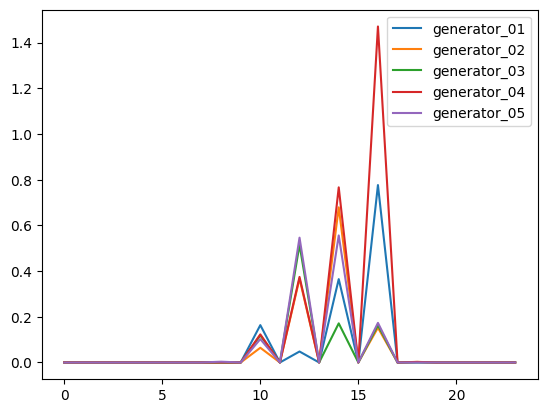

In [28]:
# Plot the generator power output

plt.figure()

for i in range(5):
    plt.plot(test_env.generators[i].value)

plt.legend(['generator_{:02d}'.format(i+1) for i in range(data_ec.generator['p_forecast'].shape[0])])
plt.show()

In [32]:
test_env.generators[0].value

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.63550000e-01, 0.00000000e+00,
       4.80276065e-02, 0.00000000e+00, 3.64883333e-01, 0.00000000e+00,
       7.76613333e-01, 0.00000000e+00, 1.66666667e-06, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

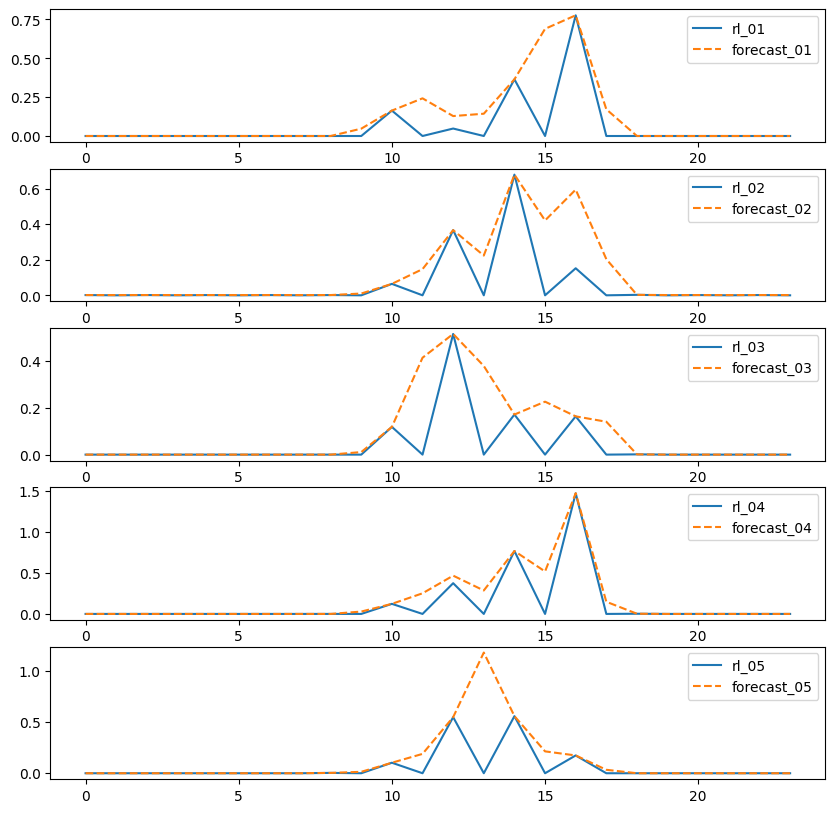

In [33]:
# Create subplots with the generator values and the forecast

fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for i in np.arange(5):
    axs[i].plot(test_env.generators[i].value, label='rl_{:02d}'.format(i+1))
    axs[i].plot(data_upacs[list(data_upacs.keys())[i]]['pv'].loc['2019-01-01'].values, label='forecast_{:02d}'.format(i+1),
                linestyle='--')
    
    axs[i].legend()
    
plt.show()

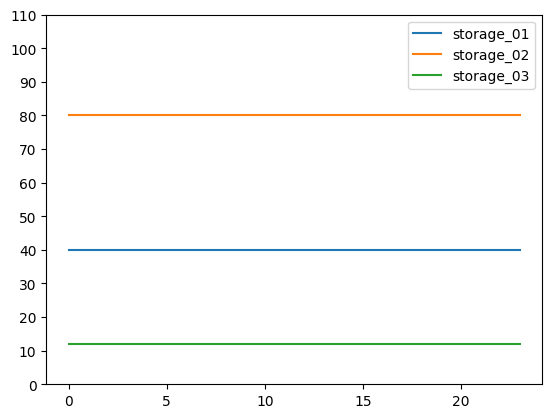

In [34]:
# Plot the storage state of charge

plt.figure()

for i in range(data_ec.storage['p_charge_limit'].shape[0]):
    plt.plot(test_env.storages[i].value * test_env.storages[i].capacity_max)
    
plt.yticks(np.arange(0, 120, 10))

plt.legend(['storage_{:02d}'.format(i+1) for i in range(data_ec.storage['p_charge_limit'].shape[0])])
plt.show()

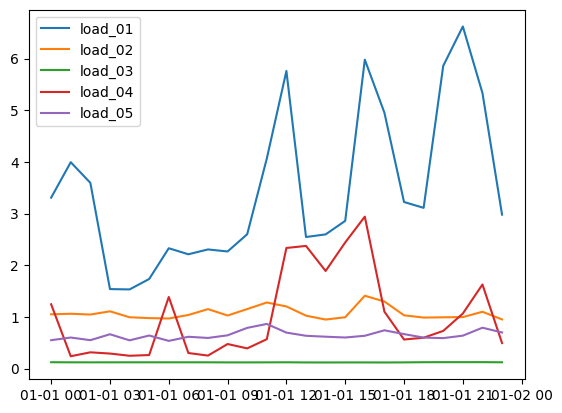

In [35]:
# Plot the load values

plt.figure()

for i in range(5):
    plt.plot(test_env.loads[i].value)
    
plt.legend(['load_{:02d}'.format(i+1) for i in range(5)])
plt.show()

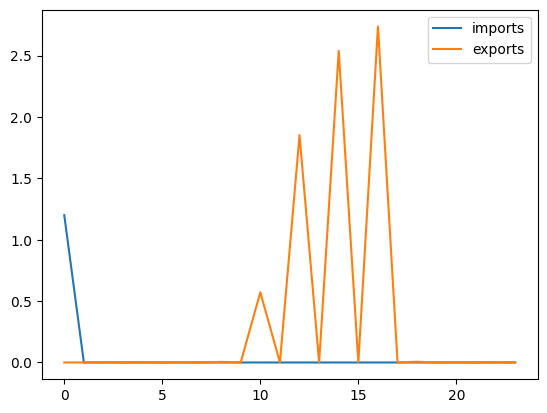

In [36]:
# Check imports and exports

plt.figure()

plt.plot(test_env.aggregator.imports, label='imports')
plt.plot(test_env.aggregator.exports, label='exports')

plt.legend()
plt.show()

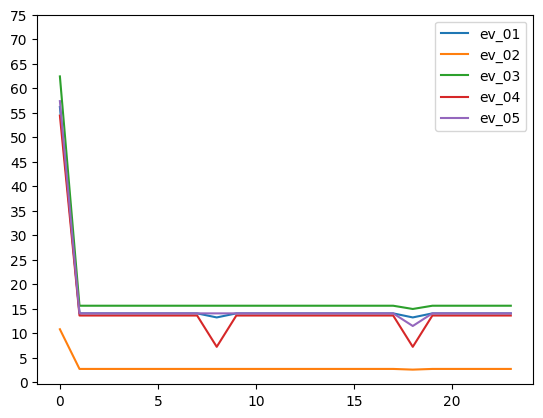

In [37]:
# Check EVs

plt.figure()

for i in test_env.evs:
    plt.plot(test_env.history[-1][str(i)].value * test_env.history[-1][str(i)].capacity_max)

plt.yticks(np.arange(0, 80, 5))
plt.legend(['ev_{:02d}'.format(i+1) for i in range(len(test_env.evs))])

plt.show()

In [11]:
list(dataset_resources.keys())[318]

'2019-11-15'

In [43]:
# Put the resources in dataframes

pd_results = pd.DataFrame({a: test_env.agents[a].value for a in test_env.agents})

# Append imports and exports
pd_results['imports'] = test_env.aggregator.imports
pd_results['exports'] = test_env.aggregator.exports

In [44]:
pd_results

,generator_08,generator_06,generator_02,generator_09,generator_13,ev_01,ev_02,ev_03,ev_04,ev_05,storage_01,storage_02,storage_03,aggregator,imports,exports
0,0.000000,0.001452,0.000000,0.000012,0.000000,0.800000,0.800000,0.800000,0.800000,0.816772,0.8,0.8,0.8,0.0,1.175942,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.8,0.8,0.8,0.0,0.000000,0.000000
2,0.000000,0.001458,0.000000,0.000025,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.8,0.8,0.8,0.0,0.000000,0.001483
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.8,0.8,0.8,0.0,0.000000,0.000000
4,0.000000,0.001430,0.000000,0.000008,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.8,0.8,0.8,0.0,0.000000,0.001438
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.8,0.8,0.8,0.0,0.000000,0.000000
6,0.000000,0.001405,0.000000,0.000012,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.8,0.8,0.8,0.0,0.000000,0.001417
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.8,0.8,0.8,0.0,0.000000,0.000000
8,0.000000,0.001438,0.000008,0.000110,0.003387,0.188182,0.200000,0.200000,0.106056,0.200000,0.8,0.8,0.8,0.0,0.000000,0.004943
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.8,0.8,0.8,0.0,0.000000,0.000000


In [46]:
pd_results.to_csv('./results/multiagent.csv')

In [15]:
# Run the policies and save results

for i in dataset_resources.keys():
    
    print('Day: {}'.format(i))
    
    test_env = EnergyCommunityMultiEnv_v2(resources=dataset_resources[i],
                                          import_penalty=IMPORT_PENALTY,
                                          export_penalty=EXPORT_PENALTY,
                                          storage_action_penalty=STORAGE_ACTION_PENALTY,
                                          storage_action_reward=STORAGE_ACTION_REWARD,
                                          ev_action_penalty=EV_ACTION_PENALTY,
                                          ev_action_reward=EV_ACTION_REWARD,
                                          ev_requirement_penalty=EV_REQUIREMENT_PENALTY,
                                          balance_penalty=BALANCE_PENALTY)
    
    obs, info = test_env.reset()
    
    # Set up the terminations and truncations
    terminations = truncations = {a: False for a in test_env.agents}
    terminations['__all__'] = False
    truncations['__all__'] = False
    
    while not terminations['__all__'] and not truncations['__all__']:
    
        action_dict = {a: algo.compute_single_action(observation=obs[a],
                                                     policy_id='generator' if a.startswith('generator') else
                                                     'storage' if a.startswith('storage') else
                                                     'ev' if a.startswith('ev') else
                                                     'aggregator') for a in temp_env.agents}
    
        obs, rewards, terminations, truncations, info = test_env.step(action_dict)
    
        if len(obs) == 0:
            obs, rewards, terminations, truncations, info = test_env.step({a: 0 for a in test_env.agents})
            terminations['__all__'] = True
            truncations['__all__'] = True
            
    pd_results = pd.DataFrame({a: test_env.agents[a].value for a in test_env.agents})
    pd_results['imports'] = test_env.aggregator.imports
    pd_results['exports'] = test_env.aggregator.exports
    
    pd_results.to_csv('./results/multiagent_{}.csv'.format(i))

Day: 2019-01-01
Day: 2019-01-02
Day: 2019-01-03
Day: 2019-01-04
Day: 2019-01-05
Day: 2019-01-06
Day: 2019-01-07
Day: 2019-01-08
Day: 2019-01-09
Day: 2019-01-10
Day: 2019-01-11
Day: 2019-01-12
Day: 2019-01-13
Day: 2019-01-14
Day: 2019-01-15
Day: 2019-01-16
Day: 2019-01-17
Day: 2019-01-18
Day: 2019-01-19
Day: 2019-01-20
Day: 2019-01-21
Day: 2019-01-22
Day: 2019-01-23
Day: 2019-01-24
Day: 2019-01-25
Day: 2019-01-26
Day: 2019-01-27
Day: 2019-01-28
Day: 2019-01-29
Day: 2019-01-30
Day: 2019-01-31
Day: 2019-02-01
Day: 2019-02-02
Day: 2019-02-03
Day: 2019-02-04
Day: 2019-02-05
Day: 2019-02-06
Day: 2019-02-07
Day: 2019-02-08
Day: 2019-02-09
Day: 2019-02-10
Day: 2019-02-11
Day: 2019-02-12
Day: 2019-02-13
Day: 2019-02-14
Day: 2019-02-15
Day: 2019-02-16
Day: 2019-02-17
Day: 2019-02-18
Day: 2019-02-19
Day: 2019-02-20
Day: 2019-02-21
Day: 2019-02-22
Day: 2019-02-23
Day: 2019-02-24
Day: 2019-02-25
Day: 2019-02-26
Day: 2019-02-27
Day: 2019-02-28
Day: 2019-03-01
Day: 2019-03-02
Day: 2019-03-03
Day: 201